In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
from IPython.display import display, Markdown
from scipy.stats import pearsonr, spearmanr, ks_2samp, mannwhitneyu, ttest_ind

import sys
sys.path.append('../')
from utilities import data

## directory where results are
EXPERIMENT_DIR = f"/data/bodyct/experiments/lung-malignancy-fairness-shaurya"
NLST_PREDS = f"{EXPERIMENT_DIR}/nlst"

TEAMS_DIR = "C:/Users/shaur/OneDrive - Radboudumc/Documents - Master - Shaurya Gaur/General/Malignancy-Estimation Results"
NLST_PREDS = f"{TEAMS_DIR}/nlst" ## Comment out if not using Teams backup (aka Chansey is up :)

In [2]:
nlst_preds_nodule = pd.read_csv(f"{NLST_PREDS}/nlst_demov4_allmodels_cal.csv")
nlst_preds_nodule.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16077 entries, 0 to 16076
Columns: 128 entries, PatientID to NoduleType
dtypes: bool(27), float64(86), int64(11), object(4)
memory usage: 12.8+ MB


In [3]:
with open(f'{NLST_PREDS}/nlst_demo_v4_cols.json') as json_data:
    nlst_democols = json.load(json_data)
    json_data.close()

In [4]:
# nlst_democols['num'].pop('nodule')

In [5]:
nlst_democols['num']['other'].append('Mean_Entropy_Kiran')

In [6]:
nlst_democols

{'num': {'demo': ['BMI', 'Age', 'height', 'weight'],
  'smoke': ['smokeage', 'smokeday', 'smokeyr', 'pkyr'],
  'nodule': ['CoordX', 'CoordZ', 'CoordY'],
  'other': ['NoduleCounts', 'Diameter [mm]', 'Mean_Entropy_Kiran']},
 'cat': {'demo': ['Overweight',
   'educat',
   'Gender',
   'Married',
   'HighSchoolPlus',
   'NonHispanicWhite',
   'Unfinished_ed',
   'WhiteOrBlack',
   'marital',
   'ethnic',
   'race'],
  'smoke': ['smokelive', 'cigar', 'cigsmok', 'smokework', 'pipe'],
  'work': ['wrkbaki',
   'wrkfoun',
   'wrkchem',
   'wrkasbe',
   'wrkfire',
   'wrksand',
   'wrkfarm',
   'wrkcoal',
   'wrkpain',
   'wrkweld',
   'wrkflou',
   'wrkbutc',
   'wrkhard',
   'wrkcott'],
  'disease': ['diagasbe',
   'diagchas',
   'diagpneu',
   'diagstro',
   'diagemph',
   'diagbron',
   'diagsili',
   'diagsarc',
   'diaghear',
   'diagdiab',
   'diagadas',
   'diagcopd',
   'diagfibr',
   'diagtube',
   'diaghype',
   'diagchro'],
  'canchist': ['canckidn',
   'cancphar',
   'canccolo',
   

In [7]:
nlst_preds = data.prep_nlst_preds(nlst_preds_nodule, scanlevel=False, tijmen=False, sybil=False)
nlst_preds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16077 entries, 0 to 16076
Columns: 128 entries, PatientID to NoduleType
dtypes: bool(27), float64(86), int64(11), object(4)
memory usage: 12.8+ MB


In [8]:
# nlst_policy_thresholds = pd.read_csv(f"{NLST_PREDS}/policy-thresholds-{len(nlst_preds)}.csv", index_col=0)
# nlst_policy_thresholds

In [9]:
THRESHOLD = 'Brock'

In [10]:
nlst_preds['WhiteOrBlack'] = nlst_preds['race'].replace([3, 4, 5, 6], value=np.nan, inplace=False)
nlst_democols['cat']['demo'].append('WhiteOrBlack')

In [11]:
MODEL_TO_COL = {
    "Venkadesh": "DL_cal",
    # "de Haas Combined": "Thijmen_mean_cal",
    "de Haas Local": "Thijmen_local_cal",
    "de Haas Global (hidden nodule)": "Thijmen_global_hidden",
    "de Haas Global (w/nodule)": "Thijmen_global_show_cal",
    "Sybil": "sybil_year1",
    "PanCan2b": "PanCan2b",
}

In [12]:
# nlst_preds['Kiran_pred_label'] = (nlst_preds[MODEL_TO_COL['Venkadesh']] > nlst_policy_thresholds.loc['Venkadesh', THRESHOLD]).astype(int).to_numpy()
nlst_preds['Kiran_pred_label'] = (nlst_preds[MODEL_TO_COL['Venkadesh']] > 0.06).astype(int).to_numpy()
nlst_preds['Kiran_PanCan_diff'] = nlst_preds[MODEL_TO_COL['Venkadesh']] - nlst_preds['PanCan2b']

In [13]:
false_positives = nlst_preds_nodule.query("label == 0 and Kiran_pred_label == 1")
false_negatives = nlst_preds_nodule.query("label == 1 and Kiran_pred_label == 0")

true_positives = nlst_preds_nodule.query("label == 1 and Kiran_pred_label == 1")
true_negatives = nlst_preds_nodule.query("label == 0 and Kiran_pred_label == 0")

## Difference between Training Info Splits

In [14]:
result_sets = {
    "FP": false_positives,
    "FN": false_negatives,
    "TP": true_positives,
    "TN": true_negatives, 
}

### utility code

In [15]:
def combine_col_dfs(cols=nlst_democols['cat'], df_func=pd.DataFrame, dfsets=result_sets, dispdf=False):
    splitdfs = []
    for cat in cols:
        if dispdf: display(Markdown(f"### {cat}"))
        
        for c in cols[cat]:
            df = df_func(c, dfsets)
            if dispdf: display(df)

            df['category'] = [cat] * len(df)
            df['attribute'] = [c] * len(df)
            df['value'] = df.index.values
            
            dfcols = df.columns.tolist()
            dfcols = dfcols[-3:] + dfcols[:-3]
            df = df[dfcols]
            df.reset_index(inplace=True, drop=True)
            df.sort_values(by='value', ascending=True, inplace=True)

            splitdfs.append(df)

    return pd.concat(splitdfs, axis=0, ignore_index=True)

In [16]:
def cat_dist_df(c='Gender', dfsets=result_sets):
    dfdict = {}
    for m in dfsets:
        dfdict[f"{m}_freq"] = dfsets[m][c].value_counts(normalize=False, dropna=False).astype(int)
        dfdict[f"{m}_norm"] = 100 * dfsets[m][c].value_counts(normalize=True, dropna=False).round(6)
        dfdict[f"{m}_freq"].fillna(0, inplace=True)
        dfdict[f"{m}_norm"].fillna(0, inplace=True)
    
    for i, m1 in enumerate(dfsets):
        for j, m2 in enumerate(dfsets):
            if j > i:
                # dfdict[f"diff_freq_{m1}_{m2}"] = (dfdict[f"{m1}_freq"] - dfdict[f"{m2}_freq"]).round(4)
                dfdict[f"diff_norm_{m1}_{m2}"] = (dfdict[f"{m1}_norm"] - dfdict[f"{m2}_norm"]).round(4)
    
    df = pd.DataFrame(dfdict).drop_duplicates()

    for m in dfsets:
        df[f"{m}_freq"] = df[f"{m}_freq"].fillna(0.0)
        df[f"{m}_norm"] = df[f"{m}_norm"].fillna(0.0)

    for i, m1 in enumerate(dfsets):
        for j, m2 in enumerate(dfsets):
            if j > i:
                # dfdict[f"diff_freq_{m1}_{m2}"] = (dfdict[f"{m1}_freq"] - dfdict[f"{m2}_freq"]).round(4)
                df[f"diff_norm_{m1}_{m2}"] = (df[f"{m1}_norm"] - df[f"{m2}_norm"]).round(4)    

    # df = pd.DataFrame(dfdict).drop_duplicates()
    return df

In [17]:
def num_dist_df(c='Gender', dfsets=result_sets):
    dfdict = {}
    for m in dfsets:
        dfdict[f"{m}"] = dfsets[m][c].describe(percentiles=[0.5]).round(4)
    
    for i, m1 in enumerate(dfsets):
        for j, m2 in enumerate(dfsets):
            if j > i:
                dfdict[f"diff_{m1}_{m2}"] = dfdict[f"{m1}"] - dfdict[f"{m2}"]
    
    df = pd.DataFrame(dfdict).drop_duplicates()
    df.drop(index=['count', 'max', 'min', 'std'], inplace=True)
    return df

### differences

In [18]:
cat_demo_splits = combine_col_dfs(nlst_democols['cat'], cat_dist_df, result_sets).query('value != 0')
display(cat_demo_splits.sort_values(by='diff_norm_FP_FN', ascending=False).head(30))
cat_demo_splits.sort_values(by='diff_norm_FP_FN', ascending=True).head(30)

,category,attribute,value,FP_freq,FP_norm,FN_freq,FN_norm,TP_freq,TP_norm,TN_freq,TN_norm,diff_norm_FP_FN,diff_norm_FP_TP,diff_norm_FP_TN,diff_norm_FN_TP,diff_norm_FN_TN,diff_norm_TP_TN
224,lungcanc,LC_stage,NaN,3414.0,100.0000,3.0,2.1127,28.0,2.5294,11414.0,100.0000,97.8873,97.4706,0.0000,-0.4167,-97.8873,-97.4706
207,nodule,SemiSolid,1.0,757.0,22.1734,0.0,0.0000,0.0,0.0000,715.0,6.2642,22.1734,22.1734,15.9092,0.0000,-6.2642,-6.2642
191,nodule,GroundGlassOpacity,1.0,635.0,18.5999,0.0,0.0000,0.0,0.0000,2976.0,26.0732,18.5999,18.5999,-7.4733,0.0000,-26.0732,-26.0732
10,demo,Gender,1.0,2008.0,58.8166,71.0,50.0000,656.0,59.2593,6546.0,57.3506,8.8166,-0.4427,1.4660,-9.2593,-7.3506,1.9087
19,demo,Unfinished_ed,1.0,964.0,28.2367,29.0,20.4225,349.0,31.5266,3069.0,26.8880,7.8142,-3.2899,1.3487,-11.1041,-6.4655,4.6386
6,demo,educat,5.0,736.0,21.5583,23.0,16.1972,281.0,25.3839,2499.0,21.8942,5.3611,-3.8256,-0.3359,-9.1867,-5.6970,3.4897
27,demo,marital,5.0,626.0,18.3363,19.0,13.3803,240.0,21.6802,2072.0,18.1531,4.9560,-3.3439,0.1832,-8.2999,-4.7728,3.5271
75,work,wrkfarm,1.0,454.0,13.2982,12.0,8.4507,109.0,9.8464,1245.0,10.9077,4.8475,3.4518,2.3905,-1.3957,-2.4570,-1.0613
54,smoke,pipe,1.0,765.0,22.4077,25.0,17.6056,272.0,24.5709,2376.0,20.8165,4.8021,-2.1632,1.5912,-6.9653,-3.2109,3.7544
213,other,wrknomask,1.0,945.0,27.6801,33.0,23.2394,273.0,24.6612,2785.0,24.3999,4.4407,3.0189,3.2802,-1.4218,-1.1605,0.2613


,category,attribute,value,FP_freq,FP_norm,FN_freq,FN_norm,TP_freq,TP_norm,TN_freq,TN_norm,diff_norm_FP_FN,diff_norm_FP_TP,diff_norm_FP_TN,diff_norm_FN_TP,diff_norm_FN_TN,diff_norm_TP_TN
216,lungcanc,LC_stage,110.0,0.0,0.0000,91.0,64.0845,534.0,48.2385,0.0,0.0000,-64.0845,-48.2385,0.0000,15.8460,64.0845,48.2385
234,lungcanc,Adenocarcinoma,1.0,0.0,0.0000,61.0,42.9577,500.0,45.1671,0.0,0.0000,-42.9577,-45.1671,0.0000,-2.2094,42.9577,45.1671
236,lungcanc,Squamous_cell_carcinoma,1.0,0.0,0.0000,33.0,23.2394,211.0,19.0605,0.0,0.0000,-23.2394,-19.0605,0.0000,4.1789,23.2394,19.0605
197,nodule,NonSolid,1.0,0.0,0.0000,29.0,20.4225,97.0,8.7624,0.0,0.0000,-20.4225,-8.7624,0.0000,11.6601,20.4225,8.7624
203,nodule,PartSolid,1.0,0.0,0.0000,24.0,16.9014,221.0,19.9639,0.0,0.0000,-16.9014,-19.9639,0.0000,-3.0625,16.9014,19.9639
230,lungcanc,Bronchiolo-alveolar_carcinoma,1.0,0.0,0.0000,23.0,16.1972,163.0,14.7245,0.0,0.0000,-16.1972,-14.7245,0.0000,1.4727,16.1972,14.7245
209,other,FamilyHistoryLungCa,1.0,874.0,25.6005,52.0,36.6197,327.0,29.5393,2845.0,24.9255,-11.0192,-3.9388,0.6750,7.0804,11.6942,4.6138
193,nodule,NoduleInUpperLung,1.0,1814.0,53.1342,90.0,63.3803,676.0,61.0659,4166.0,36.4990,-10.2461,-7.9317,16.6352,2.3144,26.8813,24.5669
238,lungcanc,Unclassified_carcinoma,1.0,0.0,0.0000,14.0,9.8592,110.0,9.9368,0.0,0.0000,-9.8592,-9.9368,0.0000,-0.0776,9.8592,9.9368
222,lungcanc,LC_stage,400.0,0.0,0.0000,13.0,9.1549,163.0,14.7245,0.0,0.0000,-9.1549,-14.7245,0.0000,-5.5696,9.1549,14.7245


In [19]:
num_demo_splits = combine_col_dfs(nlst_democols['num'], num_dist_df, result_sets)
display(num_demo_splits.sort_values(by='diff_FP_FN', ascending=False).head(30))
num_demo_splits.sort_values(by='diff_FP_FN', ascending=True).head(30)

,category,attribute,value,FP,FN,TP,TN,diff_FP_FN,diff_FP_TP,diff_FP_TN,diff_FN_TP,diff_FN_TN,diff_TP_TN
20,nodule,CoordY,50%,0.3350,-17.8450,1.3408,-52.5700,18.1800,-1.0058,52.9050,-19.1858,34.7250,53.9108
21,nodule,CoordY,mean,-23.8909,-29.6896,-23.1025,-50.6893,5.7987,-0.7884,26.7984,-6.5871,20.9997,27.5868
25,other,Diameter [mm],mean,11.1547,8.3972,15.1142,6.3864,2.7575,-3.9595,4.7683,-6.7170,2.0108,8.7278
24,other,Diameter [mm],50%,9.6000,7.4500,12.8000,5.5000,2.1500,-3.2000,4.1000,-5.3500,1.9500,7.3000
7,demo,weight,mean,179.4982,177.9155,175.4596,184.0172,1.5827,4.0386,-4.5190,2.4559,-6.1017,-8.5576
6,demo,weight,50%,177.0000,175.5000,173.0000,180.0000,1.5000,4.0000,-3.0000,2.5000,-4.5000,-7.0000
5,demo,height,mean,68.0690,67.3944,67.8397,67.9519,0.6746,0.2293,0.1171,-0.4453,-0.5575,-0.1122
23,other,NoduleCounts,mean,2.4241,2.1620,2.4119,2.6129,0.2621,0.0122,-0.1888,-0.2499,-0.4509,-0.2010
11,smoke,smokeday,mean,28.6593,28.5634,30.0750,28.4119,0.0959,-1.4157,0.2474,-1.5116,0.1515,1.6631
27,other,Mean_Entropy_Kiran,mean,0.3201,0.2987,0.2939,0.2647,0.0214,0.0262,0.0554,0.0048,0.0340,0.0292


,category,attribute,value,FP,FN,TP,TN,diff_FP_FN,diff_FP_TP,diff_FP_TN,diff_FN_TP,diff_FN_TN,diff_TP_TN
19,nodule,CoordZ,mean,39.2967,63.7262,66.6946,-14.3776,-24.4295,-27.3979,53.6743,-2.9684,78.1038,81.0722
18,nodule,CoordZ,50%,-126.4200,-106.8800,-112.5100,-157.0500,-19.5400,-13.9100,30.6300,5.6300,50.1700,44.5400
16,nodule,CoordX,50%,-36.4850,-24.0404,-37.7200,-46.4200,-12.4446,1.2350,9.9350,13.6796,22.3796,8.7000
14,smoke,pkyr,50%,51.2500,54.0000,57.0000,50.0000,-2.7500,-5.7500,1.2500,-3.0000,4.0000,7.0000
17,nodule,CoordX,mean,-10.1376,-7.4994,-10.6165,-14.6133,-2.6382,0.4789,4.4757,3.1171,7.1139,3.9968
15,smoke,pkyr,mean,58.8407,60.9975,64.9514,57.1976,-2.1568,-6.1107,1.6431,-3.9539,3.7999,7.7538
12,smoke,smokeyr,50%,41.0000,43.0000,44.0000,41.0000,-2.0000,-3.0000,0.0000,-1.0000,2.0000,3.0000
13,smoke,smokeyr,mean,41.5146,43.0986,43.7100,40.7351,-1.5840,-2.1954,0.7795,-0.6114,2.3635,2.9749
8,smoke,smokeage,50%,16.0000,17.0000,16.0000,16.0000,-1.0000,0.0000,0.0000,1.0000,1.0000,0.0000
0,demo,BMI,50%,26.5784,27.1279,26.1672,27.2592,-0.5495,0.4112,-0.6808,0.9607,-0.1313,-1.0920


### Now with the top 100 scores that were different from PanCan

In [20]:
result_top_100_diff = {
    "FP": false_positives.sort_values(by=['Kiran_PanCan_diff'], ascending=False)[0:100],
    "FN": false_negatives.sort_values(by=['Kiran_PanCan_diff'], ascending=False)[0:100],
}

In [21]:
cat_demo_splits = combine_col_dfs(nlst_democols['cat'], cat_dist_df, result_top_100_diff).query('value != 0')
display(cat_demo_splits.sort_values(by='diff_norm_FP_FN', ascending=False).head(30))
cat_demo_splits.sort_values(by='diff_norm_FP_FN', ascending=True).head(30)

,category,attribute,value,FP_freq,FP_norm,FN_freq,FN_norm,diff_norm_FP_FN
172,lungcanc,LC_stage,NaN,100.0,100.0,1.0,1.0,99.0
156,nodule,SemiSolid,1.0,16.0,16.0,0.0,0.0,16.0
105,disease,diagchro,1.0,19.0,19.0,7.0,7.0,12.0
83,disease,diagemph,1.0,22.0,22.0,12.0,12.0,10.0
162,other,wrknomask,1.0,34.0,34.0,24.0,24.0,10.0
10,demo,Gender,1.0,61.0,61.0,52.0,52.0,9.0
142,nodule,GroundGlassOpacity,1.0,7.0,7.0,0.0,0.0,7.0
19,demo,Unfinished_ed,1.0,28.0,28.0,21.0,21.0,7.0
55,work,wrkasbe,1.0,11.0,11.0,5.0,5.0,6.0
5,demo,educat,4.0,20.0,20.0,15.0,15.0,5.0


,category,attribute,value,FP_freq,FP_norm,FN_freq,FN_norm,diff_norm_FP_FN
165,lungcanc,LC_stage,110.0,0.0,0.0,63.0,63.0,-63.0
181,lungcanc,Adenocarcinoma,1.0,0.0,0.0,49.0,49.0,-49.0
183,lungcanc,Squamous_cell_carcinoma,1.0,0.0,0.0,23.0,23.0,-23.0
148,nodule,NonSolid,1.0,0.0,0.0,17.0,17.0,-17.0
43,smoke,cigsmok,1.0,50.0,50.0,64.0,64.0,-14.0
178,lungcanc,Bronchiolo-alveolar_carcinoma,1.0,0.0,0.0,13.0,13.0,-13.0
144,nodule,NoduleInUpperLung,1.0,47.0,47.0,60.0,60.0,-13.0
158,other,FamilyHistoryLungCa,1.0,21.0,21.0,32.0,32.0,-11.0
152,nodule,PartSolid,1.0,0.0,0.0,9.0,9.0,-9.0
11,demo,Gender,2.0,39.0,39.0,48.0,48.0,-9.0


In [22]:
num_demo_splits = combine_col_dfs(nlst_democols['num'], num_dist_df, result_top_100_diff)
display(num_demo_splits.sort_values(by='diff_FP_FN', ascending=False).head(30))
num_demo_splits.sort_values(by='diff_FP_FN', ascending=True).head(30)

,category,attribute,value,FP,FN,diff_FP_FN
19,nodule,CoordZ,mean,231.4671,82.7563,148.7108
20,nodule,CoordY,50%,15.1200,-19.4924,34.6124
21,nodule,CoordY,mean,-11.5051,-33.9758,22.4707
18,nodule,CoordZ,50%,-102.9100,-107.6450,4.7350
25,other,Diameter [mm],mean,11.2490,6.7890,4.4600
24,other,Diameter [mm],50%,10.2000,6.5000,3.7000
7,demo,weight,mean,179.8600,178.4300,1.4300
2,demo,Age,50%,64.0000,63.0000,1.0000
6,demo,weight,50%,180.0000,179.0000,1.0000
23,other,NoduleCounts,mean,2.6000,2.0500,0.5500


,category,attribute,value,FP,FN,diff_FP_FN
16,nodule,CoordX,50%,-41.7900,-21.8150,-19.9750
10,smoke,smokeday,50%,20.0000,30.0000,-10.0000
14,smoke,pkyr,50%,47.0000,55.7500,-8.7500
17,nodule,CoordX,mean,-11.2890,-3.1082,-8.1808
15,smoke,pkyr,mean,56.7375,62.1700,-5.4325
12,smoke,smokeyr,50%,41.0000,43.0000,-2.0000
13,smoke,smokeyr,mean,41.4000,43.3400,-1.9400
11,smoke,smokeday,mean,27.4100,28.8900,-1.4800
0,demo,BMI,50%,26.2295,27.1279,-0.8984
9,smoke,smokeage,mean,16.2400,16.6500,-0.4100


## False Positives

In [23]:
false_positives = nlst_preds_nodule.query("label == 0 and Kiran_pred_label == 1")
false_positives.sort_values(by=['Kiran_PanCan_diff'], ascending=False)[['SeriesInstanceUID', 'label', 'Kiran_pred_label', 'PanCan2b', 'DL_cal', 'Kiran_PanCan_diff']]

,SeriesInstanceUID,label,Kiran_pred_label,PanCan2b,DL_cal,Kiran_PanCan_diff
4936,1.2.840.113654.2.55.98861299711525430877993378...,0,1,0.027097,0.870740,0.843643
12235,1.3.6.1.4.1.14519.5.2.1.7009.9004.337737422324...,0,1,0.032591,0.821022,0.788431
12534,1.3.6.1.4.1.14519.5.2.1.7009.9004.317792465838...,0,1,0.030209,0.794943,0.764734
10987,1.3.6.1.4.1.14519.5.2.1.7009.9004.305261900952...,0,1,0.133418,0.830687,0.697270
15527,1.3.6.1.4.1.14519.5.2.1.7009.9004.101975354069...,0,1,0.111572,0.795541,0.683969
...,...,...,...,...,...,...
9682,1.2.840.113654.2.55.12214417867856293761715489...,0,1,0.641022,0.152304,-0.488718
5908,1.2.840.113654.2.55.40114302739641107006168416...,0,1,0.597842,0.069518,-0.528324
7944,1.2.840.113654.2.55.98591848380988807922321793...,0,1,0.726740,0.177436,-0.549304
11899,1.3.6.1.4.1.14519.5.2.1.7009.9004.147148054836...,0,1,0.693475,0.109388,-0.584087


<Axes: xlabel='Kiran_PanCan_diff', ylabel='Count'>

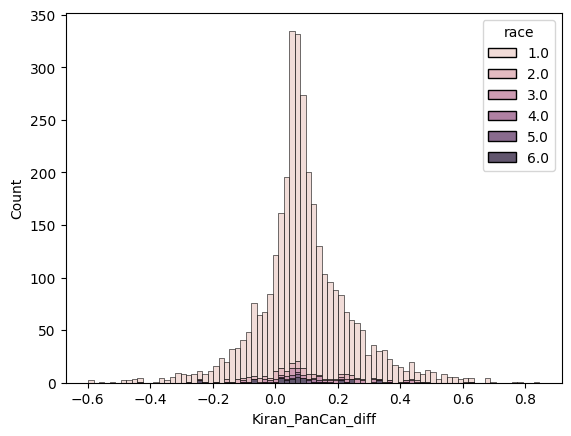

In [24]:
sns.histplot(false_positives, x='Kiran_PanCan_diff', hue='race', multiple='stack')

### Racial differences

In [25]:
race_fps = {
    "white": false_positives.query("race == 1"),
    "black": false_positives.query("race == 2"),
}

In [26]:
cat_demo_splits = combine_col_dfs(nlst_democols['cat'], cat_dist_df, race_fps).query('value != 0')
display(cat_demo_splits.sort_values(by='diff_norm_white_black', ascending=False).head(30))
cat_demo_splits.sort_values(by='diff_norm_white_black', ascending=True).head(30)

,category,attribute,value,white_freq,white_norm,black_freq,black_norm,diff_norm_white_black
20,demo,WhiteOrBlack,1.0,3187.0,100.0000,0.0,0.0000,100.0000
31,demo,race,1.0,3187.0,100.0000,0.0,0.0000,100.0000
33,demo,WhiteOrBlack,1.0,3187.0,100.0000,0.0,0.0000,100.0000
17,demo,NonHispanicWhite,True,3137.0,98.4311,0.0,0.0000,98.4311
23,demo,marital,2.0,2151.0,67.4929,36.0,38.7097,28.7832
13,demo,Married,True,2151.0,67.4929,36.0,38.7097,28.7832
47,smoke,pipe,1.0,753.0,23.6272,5.0,5.3763,18.2509
63,work,wrkfarm,1.0,432.0,13.5551,0.0,0.0000,13.5551
4,demo,educat,3.0,861.0,27.0160,14.0,15.0538,11.9622
36,smoke,smokelive,1.0,2806.0,88.0452,72.0,77.4194,10.6258


,category,attribute,value,white_freq,white_norm,black_freq,black_norm,diff_norm_white_black
32,demo,race,2.0,0.0,0.0000,93.0,100.0000,-100.0000
34,demo,WhiteOrBlack,2.0,0.0,0.0000,93.0,100.0000,-100.0000
21,demo,WhiteOrBlack,2.0,0.0,0.0000,93.0,100.0000,-100.0000
19,demo,Unfinished_ed,True,884.0,27.7377,52.0,55.9140,-28.1763
42,smoke,cigsmok,1,1566.0,49.1371,66.0,70.9677,-21.8306
120,disease,diaghype,1.0,1107.0,34.7349,51.0,54.8387,-20.1038
3,demo,educat,2.0,202.0,6.3382,21.0,22.5806,-16.2424
24,demo,marital,3.0,290.0,9.0995,22.0,23.6559,-14.5564
56,work,wrkasbe,1.0,158.0,4.9576,17.0,18.2796,-13.3220
6,demo,educat,5.0,682.0,21.3994,31.0,33.3333,-11.9339


In [27]:
num_demo_splits = combine_col_dfs(nlst_democols['num'], num_dist_df, race_fps)
display(num_demo_splits.sort_values(by='diff_white_black', ascending=False).head(30))
num_demo_splits.sort_values(by='diff_white_black', ascending=True).head(30)

,category,attribute,value,white,black,diff_white_black
19,nodule,CoordZ,mean,13.9826,-72.5262,86.5088
20,nodule,CoordY,50%,0.1400,-72.8500,72.9900
21,nodule,CoordY,mean,-23.8820,-61.3813,37.4993
14,smoke,pkyr,50%,52.0000,45.0000,7.0000
18,nodule,CoordZ,50%,-128.4300,-135.2700,6.8400
15,smoke,pkyr,mean,59.0245,52.8817,6.1428
16,nodule,CoordX,50%,-36.5600,-41.7200,5.1600
10,smoke,smokeday,50%,25.0000,20.0000,5.0000
11,smoke,smokeday,mean,28.7311,23.9785,4.7526
8,smoke,smokeage,50%,16.0000,15.0000,1.0000


,category,attribute,value,white,black,diff_white_black
6,demo,weight,50%,177.0000,180.0000,-3.0000
12,smoke,smokeyr,50%,41.0000,44.0000,-3.0000
13,smoke,smokeyr,mean,41.5171,43.8710,-2.3539
24,other,Diameter [mm],50%,9.6000,11.4000,-1.8000
25,other,Diameter [mm],mean,11.1333,12.0419,-0.9086
5,demo,height,mean,68.1033,68.4348,-0.3315
2,demo,Age,50%,63.0000,63.0000,0.0000
4,demo,height,50%,68.0000,68.0000,0.0000
22,other,NoduleCounts,50%,2.0000,2.0000,0.0000
27,other,Mean_Entropy_Kiran,mean,0.3213,0.3066,0.0147


## False Negatives

In [28]:
false_negatives.sort_values(by=['Kiran_PanCan_diff'], ascending=True)[['SeriesInstanceUID', 'label', 'Kiran_pred_label', 'PanCan2b', 'DL_cal', 'Kiran_PanCan_diff']]

,SeriesInstanceUID,label,Kiran_pred_label,PanCan2b,DL_cal,Kiran_PanCan_diff
15557,1.3.6.1.4.1.14519.5.2.1.7009.9004.143586271866...,1,0,0.525368,0.051651,-0.473717
15555,1.3.6.1.4.1.14519.5.2.1.7009.9004.175985546338...,1,0,0.481470,0.015758,-0.465713
15556,1.3.6.1.4.1.14519.5.2.1.7009.9004.276011104552...,1,0,0.450988,0.040701,-0.410287
10954,1.3.6.1.4.1.14519.5.2.1.7009.9004.132150608450...,1,0,0.435912,0.050518,-0.385394
9826,1.2.840.113654.2.55.12881149774656140035795514...,1,0,0.403346,0.021186,-0.382160
...,...,...,...,...,...,...
9276,1.2.840.113654.2.55.15505637602509032624908092...,1,0,0.009398,0.052898,0.043500
4316,1.2.840.113654.2.55.43097405894809947626255571...,1,0,0.014876,0.058605,0.043729
6666,1.2.840.113654.2.55.52319464844254142957182638...,1,0,0.005617,0.050282,0.044665
5243,1.2.840.113654.2.55.21791708195072249329063941...,1,0,0.003991,0.048763,0.044772


<Axes: xlabel='Kiran_PanCan_diff', ylabel='Count'>

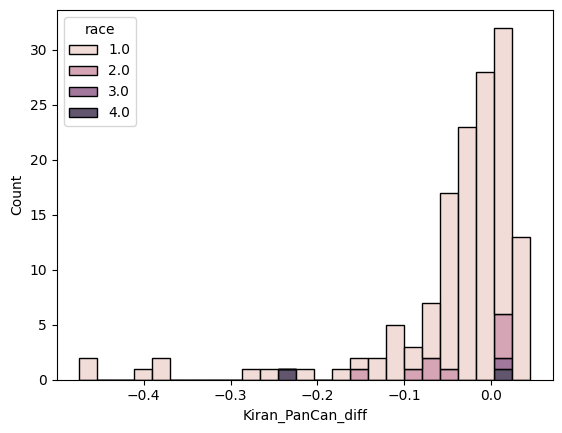

In [29]:
sns.histplot(false_negatives, x='Kiran_PanCan_diff', hue='race', multiple='stack')

### Racial differences

In [30]:
race_fns = {
    "white": false_negatives.query("race == 1"),
    "black": false_negatives.query("race == 2"),
}

In [31]:
for m in race_fns:
    print(m, len(race_fns[m]))

white 130
black 9


In [32]:
cat_demo_splits = combine_col_dfs(nlst_democols['cat'], cat_dist_df, race_fns).query('value != 0')
display(cat_demo_splits.sort_values(by='diff_norm_white_black', ascending=False).head(30))
cat_demo_splits.sort_values(by='diff_norm_white_black', ascending=True).head(30)

,category,attribute,value,white_freq,white_norm,black_freq,black_norm,diff_norm_white_black
19,demo,WhiteOrBlack,1.0,130.0,100.0000,0.0,0.0000,100.0000
16,demo,NonHispanicWhite,1.0,130.0,100.0000,0.0,0.0000,100.0000
29,demo,WhiteOrBlack,1.0,130.0,100.0000,0.0,0.0000,100.0000
27,demo,race,1.0,130.0,100.0000,0.0,0.0000,100.0000
161,lungcanc,Squamous_cell_carcinoma,1.0,32.0,24.6154,0.0,0.0000,24.6154
35,smoke,cigar,1.0,28.0,21.5385,0.0,0.0000,21.5385
142,lungcanc,LC_stage,110.0,84.0,64.6154,4.0,44.4444,20.1710
14,demo,HighSchoolPlus,1.0,127.0,97.6923,7.0,77.7778,19.9145
42,smoke,pipe,1.0,25.0,19.2308,0.0,0.0000,19.2308
9,demo,Gender,1.0,67.0,51.5385,3.0,33.3333,18.2052


,category,attribute,value,white_freq,white_norm,black_freq,black_norm,diff_norm_white_black
20,demo,WhiteOrBlack,2.0,0.0,0.0000,9.0,100.0000,-100.0000
28,demo,race,2.0,0.0,0.0000,9.0,100.0000,-100.0000
30,demo,WhiteOrBlack,2.0,0.0,0.0000,9.0,100.0000,-100.0000
37,smoke,cigsmok,1.0,71.0,54.6154,9.0,100.0000,-45.3846
96,disease,diaghype,1.0,50.0,38.4615,7.0,77.7778,-39.3163
139,other,wrknomask,1.0,28.0,21.5385,4.0,44.4444,-22.9059
87,disease,diagdiab,1.0,16.0,12.3077,3.0,33.3333,-21.0256
65,work,wrkbutc,1.0,2.0,1.5385,2.0,22.2222,-20.6837
44,work,wrkbaki,1.0,2.0,1.5385,2.0,22.2222,-20.6837
2,demo,educat,1.0,3.0,2.3077,2.0,22.2222,-19.9145


In [33]:
display(cat_demo_splits.sort_values(by='diff_norm_white_black', ascending=False).query('category == "nodule"'))
cat_demo_splits.sort_values(by='diff_norm_white_black', ascending=True).query('category == "nodule"')   

,category,attribute,value,white_freq,white_norm,black_freq,black_norm,diff_norm_white_black
130,nodule,PartSolid,1.0,23.0,17.6923,1.0,11.1111,6.5812
128,nodule,Spiculation,1.0,1.0,0.7692,0.0,0.0000,0.7692
125,nodule,NonSolid,1.0,27.0,20.7692,2.0,22.2222,-1.4530
122,nodule,NoduleInUpperLung,1.0,81.0,62.3077,6.0,66.6667,-4.3590
132,nodule,Solid,1.0,80.0,61.5385,6.0,66.6667,-5.1282


,category,attribute,value,white_freq,white_norm,black_freq,black_norm,diff_norm_white_black
132,nodule,Solid,1.0,80.0,61.5385,6.0,66.6667,-5.1282
122,nodule,NoduleInUpperLung,1.0,81.0,62.3077,6.0,66.6667,-4.3590
125,nodule,NonSolid,1.0,27.0,20.7692,2.0,22.2222,-1.4530
128,nodule,Spiculation,1.0,1.0,0.7692,0.0,0.0000,0.7692
130,nodule,PartSolid,1.0,23.0,17.6923,1.0,11.1111,6.5812


In [34]:
display(cat_demo_splits.sort_values(by='diff_norm_white_black', ascending=False).query('attribute == "LC_stage"'))
cat_demo_splits.sort_values(by='diff_norm_white_black', ascending=True).query('attribute == "LC_stage"')   

,category,attribute,value,white_freq,white_norm,black_freq,black_norm,diff_norm_white_black
142,lungcanc,LC_stage,110.0,84.0,64.6154,4.0,44.4444,20.1710
146,lungcanc,LC_stage,310.0,10.0,7.6923,0.0,0.0000,7.6923
144,lungcanc,LC_stage,210.0,7.0,5.3846,0.0,0.0000,5.3846
149,lungcanc,LC_stage,NaN,3.0,2.3077,0.0,0.0000,2.3077
147,lungcanc,LC_stage,320.0,1.0,0.7692,0.0,0.0000,0.7692
143,lungcanc,LC_stage,120.0,10.0,7.6923,1.0,11.1111,-3.4188
148,lungcanc,LC_stage,400.0,11.0,8.4615,2.0,22.2222,-13.7607
145,lungcanc,LC_stage,220.0,4.0,3.0769,2.0,22.2222,-19.1453


,category,attribute,value,white_freq,white_norm,black_freq,black_norm,diff_norm_white_black
145,lungcanc,LC_stage,220.0,4.0,3.0769,2.0,22.2222,-19.1453
148,lungcanc,LC_stage,400.0,11.0,8.4615,2.0,22.2222,-13.7607
143,lungcanc,LC_stage,120.0,10.0,7.6923,1.0,11.1111,-3.4188
147,lungcanc,LC_stage,320.0,1.0,0.7692,0.0,0.0000,0.7692
149,lungcanc,LC_stage,NaN,3.0,2.3077,0.0,0.0000,2.3077
144,lungcanc,LC_stage,210.0,7.0,5.3846,0.0,0.0000,5.3846
146,lungcanc,LC_stage,310.0,10.0,7.6923,0.0,0.0000,7.6923
142,lungcanc,LC_stage,110.0,84.0,64.6154,4.0,44.4444,20.1710


In [35]:
num_demo_splits = combine_col_dfs(nlst_democols['num'], num_dist_df, race_fns)
display(num_demo_splits.sort_values(by='diff_white_black', ascending=False).head(30))
num_demo_splits.sort_values(by='diff_white_black', ascending=True).head(30)

,category,attribute,value,white,black,diff_white_black
19,nodule,CoordZ,mean,46.8267,-104.5144,151.3411
17,nodule,CoordX,mean,-2.0466,-70.9500,68.9034
16,nodule,CoordX,50%,-15.4550,-65.1900,49.7350
20,nodule,CoordY,50%,-16.9300,-44.2000,27.2700
15,smoke,pkyr,mean,62.6050,41.1111,21.4939
14,smoke,pkyr,50%,55.5000,40.0000,15.5000
10,smoke,smokeday,50%,30.0000,20.0000,10.0000
11,smoke,smokeday,mean,29.3154,20.0000,9.3154
21,nodule,CoordY,mean,-28.6884,-37.2100,8.5216
4,demo,height,50%,68.0000,64.0000,4.0000


,category,attribute,value,white,black,diff_white_black
7,demo,weight,mean,178.4923,188.4444,-9.9521
1,demo,BMI,mean,27.3050,33.1619,-5.8569
0,demo,BMI,50%,27.1279,32.5531,-5.4252
18,nodule,CoordZ,50%,-111.1600,-106.2400,-4.9200
8,smoke,smokeage,50%,16.0000,20.0000,-4.0000
9,smoke,smokeage,mean,16.5308,19.3333,-2.8025
6,demo,weight,50%,175.5000,178.0000,-2.5000
2,demo,Age,50%,63.0000,65.0000,-2.0000
24,other,Diameter [mm],50%,7.4500,8.7000,-1.2500
25,other,Diameter [mm],mean,8.3531,9.2444,-0.8913


<Axes: xlabel='pkyr', ylabel='Probability'>

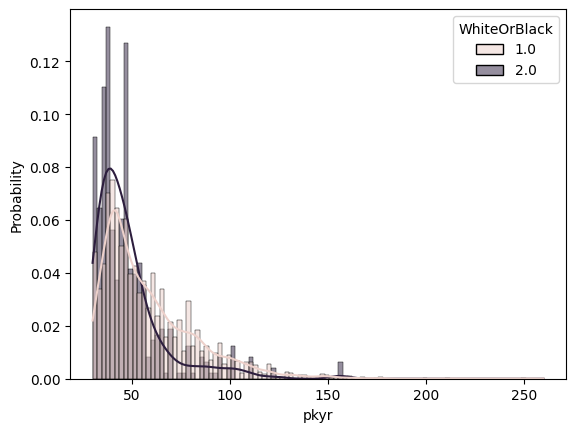

In [36]:
sns.histplot(data=nlst_preds, x='pkyr', hue='WhiteOrBlack', common_norm=False, element='bars', kde=True, stat='probability')

## Uncertainty

,count,mean,std,min,25%,50%,75%,max
NoduleType,,,,,,,,
Calcified,8.0,0.183457,0.173153,0.003378,0.030670,0.185245,0.235260,0.504920
GroundGlassOpacity,3611.0,0.285441,0.288091,0.000009,0.023826,0.171712,0.501096,0.999357
Perifissural,929.0,0.261546,0.282065,0.000014,0.019887,0.150118,0.463545,0.991514
SemiSolid,1472.0,0.279564,0.280566,0.000008,0.023073,0.181773,0.493295,0.995672
Solid,8808.0,0.275579,0.284106,0.000008,0.021224,0.163796,0.489360,0.999962


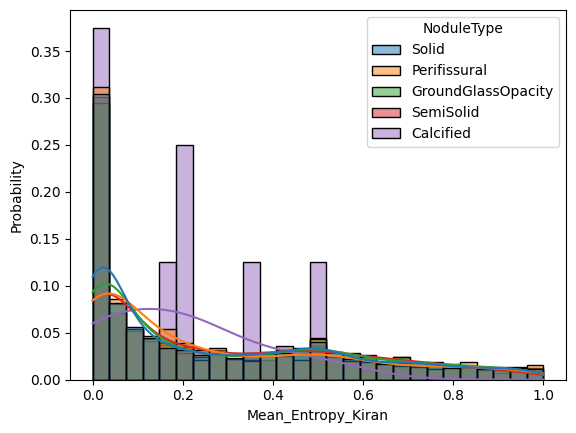

In [37]:
sns.histplot(data=nlst_preds.query('label == 0'), x='Mean_Entropy_Kiran', hue='NoduleType', common_norm=False, element='bars', kde=True, stat='probability')
nlst_preds.query('label == 0').groupby('NoduleType')['Mean_Entropy_Kiran'].describe()

,count,mean,std,min,25%,50%,75%,max
NoduleType,,,,,,,,
NonSolid,126.0,0.322435,0.293813,0.000214,0.036989,0.270275,0.512828,0.995274
PartSolid,245.0,0.288295,0.275254,0.000034,0.033197,0.194301,0.499774,0.985717
Solid,878.0,0.292170,0.280174,0.000013,0.029327,0.211334,0.498593,0.999881


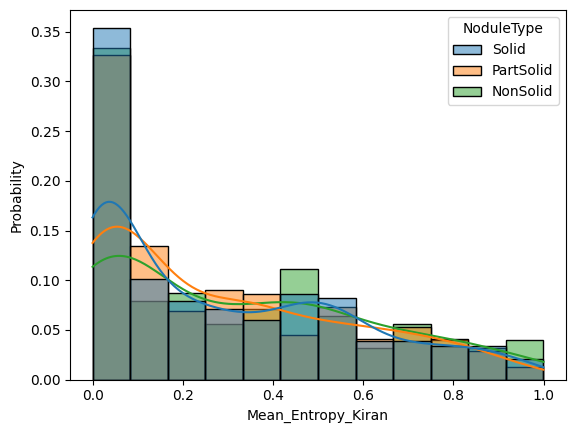

In [38]:
sns.histplot(data=nlst_preds.query('label == 1'), x='Mean_Entropy_Kiran', hue='NoduleType', common_norm=False, element='bars', kde=True, stat='probability')
nlst_preds.query('label == 1').groupby('NoduleType')['Mean_Entropy_Kiran'].describe()

,count,mean,std,min,25%,50%,75%,max
WhiteOrBlack,,,,,,,,
1.0,13895.0,0.276959,0.284546,0.000008,0.022102,0.166052,0.492327,0.999962
2.0,424.0,0.292343,0.287279,0.000029,0.027967,0.183405,0.505826,0.984429


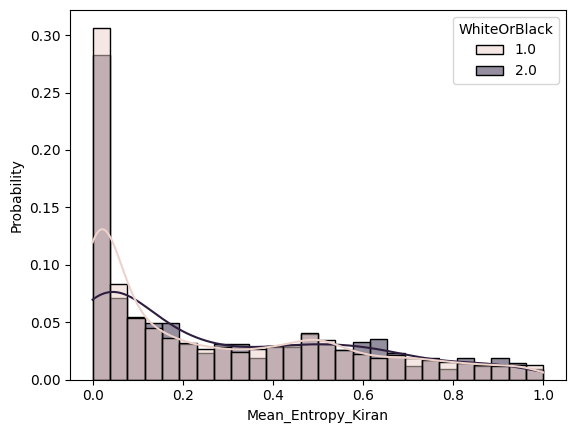

In [39]:
sns.histplot(data=nlst_preds.query('label == 0'), x='Mean_Entropy_Kiran', hue='WhiteOrBlack', common_norm=False, element='bars', kde=True, stat='probability')
nlst_preds.query('label == 0').groupby('WhiteOrBlack')['Mean_Entropy_Kiran'].describe()

,count,mean,std,min,25%,50%,75%,max
WhiteOrBlack,,,,,,,,
1.0,1145.0,0.291864,0.281165,0.000013,0.027541,0.206422,0.499353,0.999881
2.0,57.0,0.289561,0.252739,0.000656,0.070353,0.243972,0.453343,0.971731


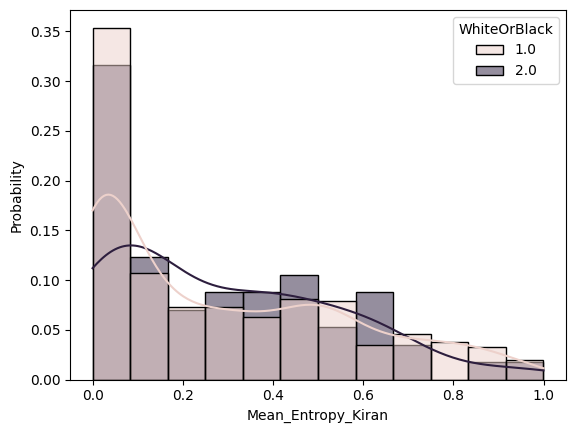

In [40]:
sns.histplot(data=nlst_preds.query('label == 1'), x='Mean_Entropy_Kiran', hue='WhiteOrBlack', common_norm=False, element='bars', kde=True, stat='probability')
nlst_preds.query('label == 1').groupby('WhiteOrBlack')['Mean_Entropy_Kiran'].describe()

,count,mean,std,min,25%,50%,75%,max
WhiteOrBlack,,,,,,,,
1.0,130.0,0.308431,0.283746,0.000465,0.030542,0.265886,0.536237,0.947602
2.0,9.0,0.230969,0.230163,0.006565,0.041603,0.095441,0.383061,0.635915


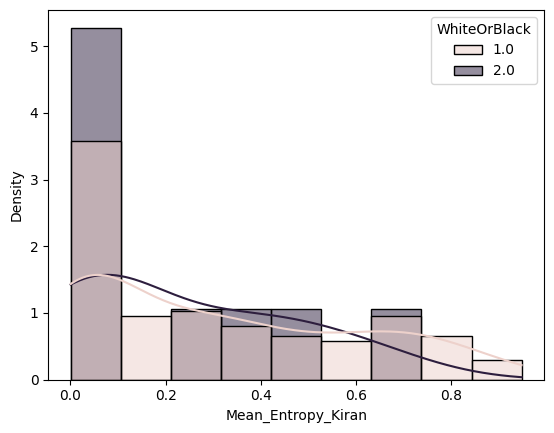

In [41]:
sns.histplot(data=false_negatives, x='Mean_Entropy_Kiran', hue='WhiteOrBlack', common_norm=False, element='bars', kde=True, stat='density')
false_negatives.groupby('WhiteOrBlack')['Mean_Entropy_Kiran'].describe()

,count,mean,std,min,25%,50%,75%,max
WhiteOrBlack,,,,,,,,
1.0,3187.0,0.321319,0.294244,0.000015,0.044414,0.245307,0.544210,0.999886
2.0,93.0,0.306644,0.300267,0.000156,0.016167,0.213393,0.535074,0.984429


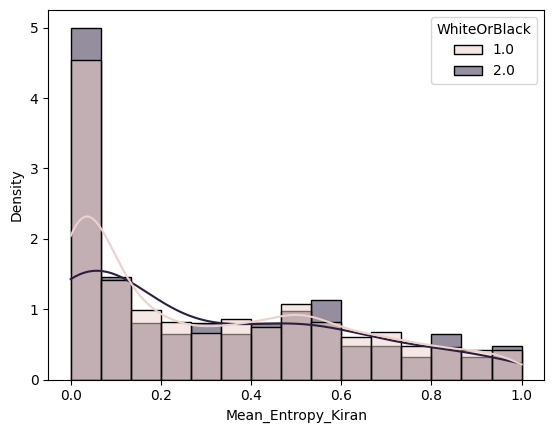

In [42]:
sns.histplot(data=false_positives, x='Mean_Entropy_Kiran', hue='WhiteOrBlack', common_norm=False, element='bars', kde=True, stat='density')
false_positives.groupby('WhiteOrBlack')['Mean_Entropy_Kiran'].describe()

,count,mean,std,min,25%,50%,75%,max
diaghype,,,,,,,,
0.0,10489.0,0.278777,0.283793,0.000008,0.022191,0.174570,0.491536,0.999881
1.0,5558.0,0.279183,0.285425,0.000008,0.023778,0.166096,0.496026,0.999962


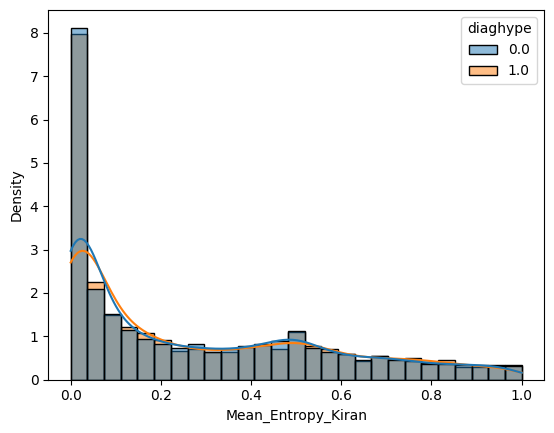

In [43]:
sns.histplot(data=nlst_preds, x='Mean_Entropy_Kiran', hue='diaghype', common_norm=False, element='bars', kde=True, stat='density')
nlst_preds.groupby('diaghype')['Mean_Entropy_Kiran'].describe()

,count,mean,std,min,25%,50%,75%,max
diaghype,,,,,,,,
0.0,83.0,0.263343,0.269072,0.000465,0.020159,0.194358,0.412891,0.947602
1.0,58.0,0.343731,0.288998,0.002928,0.060096,0.310103,0.634238,0.876993


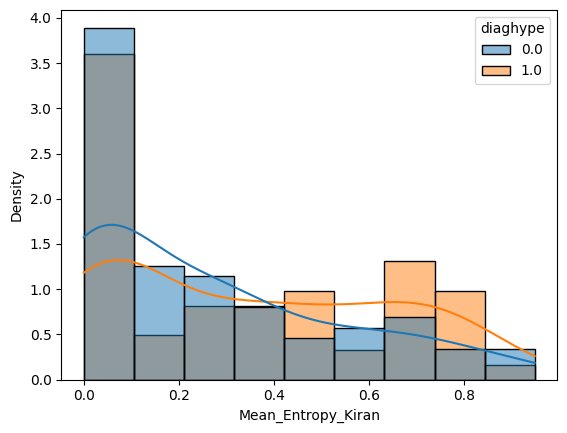

In [44]:
sns.histplot(data=false_negatives, x='Mean_Entropy_Kiran', hue='diaghype', common_norm=False, element='bars', kde=True, stat='density')
false_negatives.groupby('diaghype')['Mean_Entropy_Kiran'].describe()

,count,mean,std,min,25%,50%,75%,max
diaghype,,,,,,,,
0.0,2197.0,0.322314,0.290886,0.000040,0.048235,0.254548,0.537839,0.995672
1.0,1209.0,0.316887,0.299746,0.000015,0.035952,0.217860,0.547223,0.999886


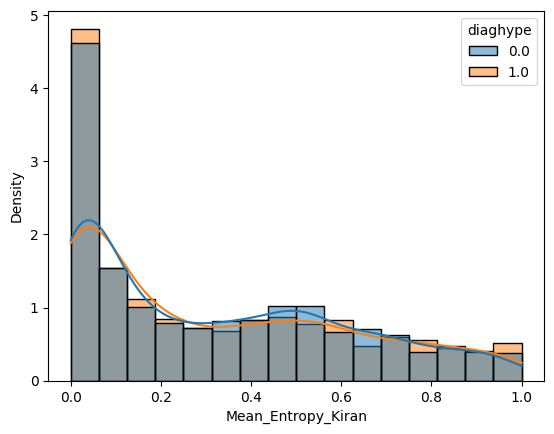

In [45]:
sns.histplot(data=false_positives, x='Mean_Entropy_Kiran', hue='diaghype', common_norm=False, element='bars', kde=True, stat='density')
false_positives.groupby('diaghype')['Mean_Entropy_Kiran'].describe()

,count,mean,std,min,25%,50%,75%,max
diaghype,,,,,,,,
0.0,798.0,0.285855,0.274361,0.000029,0.026800,0.212564,0.480938,0.999881
1.0,445.0,0.306221,0.290599,0.000013,0.038223,0.201698,0.531774,0.997483


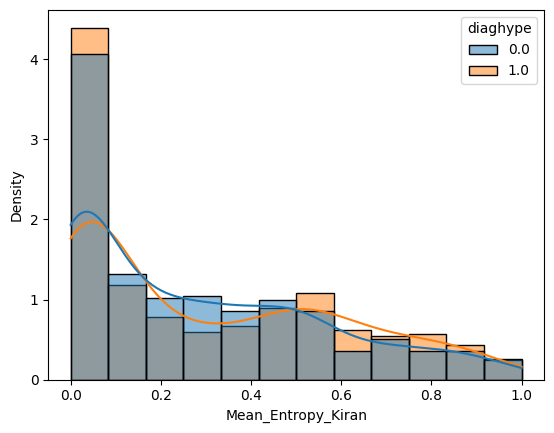

In [46]:
sns.histplot(data=nlst_preds.query('label == 1'), x='Mean_Entropy_Kiran', hue='diaghype', common_norm=False, element='bars', kde=True, stat='density')
nlst_preds.query('label == 1').groupby('diaghype')['Mean_Entropy_Kiran'].describe()

,count,mean,std,min,25%,50%,75%,max
diaghype,,,,,,,,
0.0,9691.0,0.278194,0.284561,0.000008,0.022010,0.170154,0.491978,0.999357
1.0,5113.0,0.276830,0.284878,0.000008,0.022556,0.163815,0.493411,0.999962


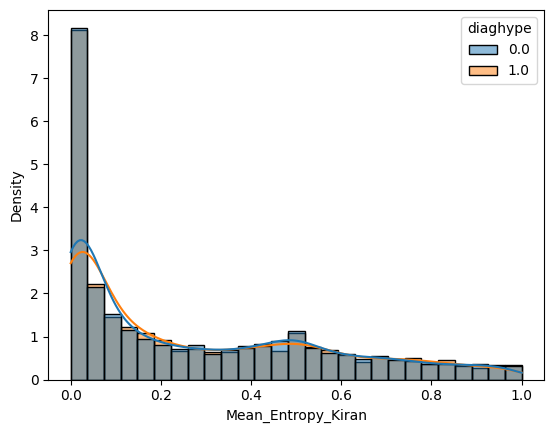

In [47]:
sns.histplot(data=nlst_preds.query('label == 0'), x='Mean_Entropy_Kiran', hue='diaghype', common_norm=False, element='bars', kde=True, stat='density')
nlst_preds.query('label == 0').groupby('diaghype')['Mean_Entropy_Kiran'].describe()

### Uncertainty by all factors

In [48]:
len(nlst_preds_nodule.query('label == 0').groupby('LC_stage')['Mean_Entropy_Kiran'])

0

In [57]:
def get_uncertainty_by_attributes(df):
    infodicts = []
    for category in nlst_democols['cat']:
        for attribute in nlst_democols['cat'][category]:
            info = {
                "category": category,
                "attribute": attribute,
                "diff_avg": 0,
                "diff_med": 0,
                "p-mannwhitney": 1,
                "p-kstest": 1,
            }
            if len(df.groupby(attribute)['Mean_Entropy_Kiran']) == 0: continue

            uncertainty_df = df.groupby(attribute)['Mean_Entropy_Kiran'].describe()
            if len(uncertainty_df) < 2: continue

            ## Get top 2 subgroups.
            uncertainty_df = uncertainty_df.sort_values(by='count', ascending=False)

            for i, (subgroup, stats) in enumerate(uncertainty_df.iterrows()):
                if i > 1: continue
                info[f"group{i+1}"] = subgroup
                info[f"group{i+1}_num"] = stats['count']
                info[f"group{i+1}_avg"] = stats['mean']
                info[f"group{i+1}_std"] = stats['std']
                info[f"group{i+1}_med"] = stats['50%']
                info[f"group{i+1}_iqr"] = stats['75%'] - stats['25%']

            info[f"diff_avg"] = info[f"group1_avg"] - info[f"group2_avg"]
            info[f"diff_med"] = info[f"group1_med"] - info[f"group2_med"]
            
            _, info["p-mannwhitney"] = mannwhitneyu(
                df[df[attribute] == info["group1"]]['Mean_Entropy_Kiran'], 
                df[df[attribute] == info["group2"]]['Mean_Entropy_Kiran'], 
                alternative='two-sided', nan_policy='omit')

            _, info["p-kstest"] = ks_2samp(
                df[df[attribute] == info["group1"]]['Mean_Entropy_Kiran'], 
                df[df[attribute] == info["group2"]]['Mean_Entropy_Kiran'], 
                alternative='two-sided', nan_policy='omit')
            
            infodicts.append(info)
    
    categorical_df = pd.DataFrame(infodicts).sort_values(by=['p-kstest', 'p-mannwhitney', 'diff_avg'], ascending=[True, True, True])

    numinfo = []
    for category in nlst_democols['num']:
        for attribute in nlst_democols['num'][category]:
            df2 = df.dropna(axis=0, subset=[attribute, 'Mean_Entropy_Kiran'])
            src, pval = spearmanr(df2['Mean_Entropy_Kiran'], df2[attribute])
            info = {
                "category": category,
                "attribute": attribute,
                "correlation": src,
                "p": pval,
            }
            numinfo.append(info)
    
    numerical_df = pd.DataFrame(numinfo).sort_values(by='p', ascending=True)
    return categorical_df, numerical_df


In [58]:
nodule_uncertainty_diffs, nodule_uncertainty_corrs = get_uncertainty_by_attributes(nlst_preds_nodule)
display(nodule_uncertainty_diffs)
display(nodule_uncertainty_corrs)

,category,attribute,diff_avg,diff_med,p-mannwhitney,p-kstest,group1,group1_num,group1_avg,group1_std,group1_med,group1_iqr,group2,group2_num,group2_avg,group2_std,group2_med,group2_iqr
73,other,Emphysema,0.014904,0.029387,0.000013,9.183673e-07,False,10385.0,0.284046,0.284824,0.180283,0.469137,True,5692.0,0.269142,0.283143,0.150896,0.471034
26,work,wrkweld,-0.020593,-0.036593,0.000465,5.788157e-05,0.0,15145.0,0.277571,0.284289,0.168648,0.470509,1.0,931.0,0.298165,0.284253,0.205241,0.462075
79,lungcanc,Adenocarcinoma,-0.024697,-0.062060,0.009756,3.897232e-03,False,15516.0,0.277908,0.284431,0.168092,0.470589,True,561.0,0.302604,0.280155,0.230153,0.463921
36,disease,diagbron,-0.046711,-0.053349,0.001036,6.608246e-03,0.0,15481.0,0.277417,0.283462,0.169574,0.469847,1.0,553.0,0.324128,0.306084,0.222923,0.532208
13,smoke,cigar,0.015653,0.020352,0.008923,7.058736e-03,0.0,13031.0,0.281572,0.285200,0.174838,0.473229,1.0,2996.0,0.265920,0.279728,0.154486,0.446516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,lungcanc,Small_cell_carcinoma,-0.000462,0.002830,0.860713,8.564891e-01,False,16027.0,0.278768,0.284363,0.170797,0.470470,True,50.0,0.279230,0.269487,0.167968,0.460139
9,demo,ethnic,-0.005002,-0.028713,0.731590,8.720263e-01,2.0,15779.0,0.278788,0.284389,0.171275,0.470470,1.0,210.0,0.283790,0.282386,0.199988,0.481658
35,disease,diagemph,-0.002870,0.006097,0.863343,8.947230e-01,0.0,14283.0,0.278773,0.283891,0.172094,0.470021,1.0,1755.0,0.281643,0.288044,0.165998,0.474629
74,lungcanc,LC_stage,-0.012737,-0.002483,0.754608,9.104723e-01,110.0,625.0,0.287505,0.273949,0.211660,0.460030,400.0,176.0,0.300242,0.288463,0.214143,0.460844


,category,attribute,correlation,p
13,other,Mean_Entropy_Kiran,1.000000,0.000000
12,other,Diameter [mm],0.028241,0.000342
11,other,NoduleCounts,-0.021721,0.005883
6,smoke,smokeyr,-0.014378,0.068293
8,nodule,CoordX,0.010573,0.180054
10,nodule,CoordY,0.008183,0.299489
7,smoke,pkyr,-0.006924,0.380046
9,nodule,CoordZ,0.006361,0.419951
1,demo,Age,0.006284,0.425615
3,demo,weight,0.005366,0.496800


In [59]:
scan_uncertainty_diffs, scan_uncertainty_corrs = get_uncertainty_by_attributes(nlst_preds)
display(scan_uncertainty_diffs)
display(scan_uncertainty_corrs)

,category,attribute,diff_avg,diff_med,p-mannwhitney,p-kstest,group1,group1_num,group1_avg,group1_std,group1_med,group1_iqr,group2,group2_num,group2_avg,group2_std,group2_med,group2_iqr
73,other,Emphysema,0.014904,0.029387,0.000013,9.183673e-07,False,10385.0,0.284046,0.284824,0.180283,0.469137,True,5692.0,0.269142,0.283143,0.150896,0.471034
26,work,wrkweld,-0.020593,-0.036593,0.000465,5.788157e-05,0.0,15145.0,0.277571,0.284289,0.168648,0.470509,1.0,931.0,0.298165,0.284253,0.205241,0.462075
79,lungcanc,Adenocarcinoma,-0.024697,-0.062060,0.009756,3.897232e-03,False,15516.0,0.277908,0.284431,0.168092,0.470589,True,561.0,0.302604,0.280155,0.230153,0.463921
36,disease,diagbron,-0.046711,-0.053349,0.001036,6.608246e-03,0.0,15481.0,0.277417,0.283462,0.169574,0.469847,1.0,553.0,0.324128,0.306084,0.222923,0.532208
13,smoke,cigar,0.015653,0.020352,0.008923,7.058736e-03,0.0,13031.0,0.281572,0.285200,0.174838,0.473229,1.0,2996.0,0.265920,0.279728,0.154486,0.446516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,lungcanc,Small_cell_carcinoma,-0.000462,0.002830,0.860713,8.564891e-01,False,16027.0,0.278768,0.284363,0.170797,0.470470,True,50.0,0.279230,0.269487,0.167968,0.460139
9,demo,ethnic,-0.005002,-0.028713,0.731590,8.720263e-01,2.0,15779.0,0.278788,0.284389,0.171275,0.470470,1.0,210.0,0.283790,0.282386,0.199988,0.481658
35,disease,diagemph,-0.002870,0.006097,0.863343,8.947230e-01,0.0,14283.0,0.278773,0.283891,0.172094,0.470021,1.0,1755.0,0.281643,0.288044,0.165998,0.474629
74,lungcanc,LC_stage,-0.012737,-0.002483,0.754608,9.104723e-01,110.0,625.0,0.287505,0.273949,0.211660,0.460030,400.0,176.0,0.300242,0.288463,0.214143,0.460844


,category,attribute,correlation,p
13,other,Mean_Entropy_Kiran,1.000000,0.000000
12,other,Diameter [mm],0.028241,0.000342
11,other,NoduleCounts,-0.021721,0.005883
6,smoke,smokeyr,-0.014378,0.068293
8,nodule,CoordX,0.010573,0.180054
10,nodule,CoordY,0.008183,0.299489
7,smoke,pkyr,-0.006924,0.380046
9,nodule,CoordZ,0.006361,0.419951
1,demo,Age,0.006284,0.425615
3,demo,weight,0.005366,0.496800


In [60]:
malignant_uncertainty_diffs, malignant_uncertainty_corrs = get_uncertainty_by_attributes(nlst_preds_nodule.query('label == 1'))
display(malignant_uncertainty_diffs)
display(malignant_uncertainty_corrs)

,category,attribute,diff_avg,diff_med,p-mannwhitney,p-kstest,group1,group1_num,group1_avg,group1_std,group1_med,group1_iqr,group2,group2_num,group2_avg,group2_std,group2_med,group2_iqr
37,disease,diagsili,0.244620,0.149455,0.098460,0.024285,0.0,1242.0,0.295660,0.280746,0.214702,0.469113,1.0,4.0,0.051041,0.032447,0.065248,0.024610
0,demo,Overweight,-0.028033,-0.082133,0.147218,0.042146,True,804.0,0.284475,0.278264,0.191518,0.464176,False,445.0,0.312508,0.284074,0.273651,0.481204
4,demo,HighSchoolPlus,-0.156533,-0.281118,0.011314,0.043279,True,1225.0,0.291455,0.279321,0.206422,0.468283,False,24.0,0.447988,0.306359,0.487541,0.514329
60,nodule,Spiculation,0.098077,0.165660,0.076529,0.047007,False,1230.0,0.295955,0.280587,0.217254,0.467780,True,19.0,0.197878,0.268163,0.051595,0.373659
5,demo,NonHispanicWhite,-0.046083,-0.098475,0.036237,0.049435,True,1131.0,0.290109,0.279900,0.205016,0.471346,False,118.0,0.336192,0.284599,0.303491,0.444933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44,disease,diagtube,-0.036708,-0.071273,0.825752,0.910037,0.0,1231.0,0.294700,0.280123,0.212332,0.468477,1.0,14.0,0.331408,0.331949,0.283605,0.462120
67,lungcanc,LC_stage,-0.012737,-0.002483,0.754608,0.910472,110.0,625.0,0.287505,0.273949,0.211660,0.460030,400.0,176.0,0.300242,0.288463,0.214143,0.460844
50,canchist,canccerv,-0.010659,-0.003865,0.935527,0.917335,0.0,1227.0,0.294030,0.280266,0.211660,0.468712,1.0,18.0,0.304689,0.300586,0.215525,0.503901
58,nodule,NoduleInUpperLung,0.006856,0.019108,0.867907,0.932616,True,766.0,0.297114,0.282482,0.221394,0.471407,False,483.0,0.290258,0.277715,0.202285,0.455241


,category,attribute,correlation,p
13,other,Mean_Entropy_Kiran,1.000000,0.000000
11,other,NoduleCounts,-0.093089,0.000989
8,nodule,CoordX,0.075930,0.007261
9,nodule,CoordZ,-0.060276,0.033168
12,other,Diameter [mm],-0.059262,0.036248
0,demo,BMI,-0.050678,0.074323
6,smoke,smokeyr,0.044986,0.112045
1,demo,Age,0.042912,0.129584
10,nodule,CoordY,-0.038505,0.173848
3,demo,weight,-0.023397,0.409847


In [61]:
benign_uncertainty_diffs, benign_uncertainty_corrs = get_uncertainty_by_attributes(nlst_preds_nodule.query('label == 0'))
display(benign_uncertainty_diffs)
display(benign_uncertainty_corrs)

,category,attribute,diff_avg,diff_med,p-mannwhitney,p-kstest,group1,group1_num,group1_avg,group1_std,group1_med,group1_iqr,group2,group2_num,group2_avg,group2_std,group2_med,group2_iqr
70,other,Emphysema,0.017769,0.034340,0.000002,1.855639e-07,False,9688.0,0.283607,0.285488,0.178037,0.469779,True,5140.0,0.265838,0.282564,0.143697,0.466527
26,work,wrkweld,-0.025565,-0.043227,0.000095,1.082584e-05,0.0,13986.0,0.275996,0.284438,0.164621,0.470510,1.0,842.0,0.301561,0.286265,0.207848,0.461601
8,demo,marital,0.015501,0.028117,0.003295,3.146464e-03,2.0,10102.0,0.277146,0.284320,0.166241,0.470362,5.0,2698.0,0.261645,0.280947,0.138124,0.452069
15,smoke,smokework,-0.017824,-0.035377,0.002082,3.691078e-03,1.0,12829.0,0.275420,0.284486,0.163813,0.470135,0.0,1899.0,0.293244,0.285374,0.199190,0.472517
31,disease,diagasbe,-0.052700,-0.112724,0.005484,9.590996e-03,0.0,14648.0,0.276891,0.284588,0.165603,0.470271,1.0,163.0,0.329591,0.282435,0.278327,0.507268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,disease,diaghype,0.001364,0.006339,0.898856,8.639095e-01,0.0,9691.0,0.278194,0.284561,0.170154,0.469968,1.0,5113.0,0.276830,0.284878,0.163815,0.470855
55,canchist,canclary,0.051450,0.093634,0.774995,8.856977e-01,0.0,14798.0,0.277642,0.284634,0.167530,0.470489,1.0,9.0,0.226192,0.253972,0.073896,0.492350
4,demo,HighSchoolPlus,-0.005124,-0.034170,0.730905,8.950017e-01,True,14584.0,0.277363,0.284668,0.166241,0.470476,False,244.0,0.282488,0.280685,0.200411,0.464832
35,disease,diagemph,-0.000369,0.006914,0.984554,9.291552e-01,0.0,13193.0,0.277717,0.284340,0.168627,0.470172,1.0,1599.0,0.278086,0.287003,0.161712,0.471548


,category,attribute,correlation,p
13,other,Mean_Entropy_Kiran,1.000000,0.000000
12,other,Diameter [mm],0.027118,0.000958
6,smoke,smokeyr,-0.021346,0.009338
11,other,NoduleCounts,-0.016902,0.039583
10,nodule,CoordY,0.010822,0.187591
7,smoke,pkyr,-0.010056,0.220777
0,demo,BMI,0.009905,0.228346
9,nodule,CoordZ,0.009006,0.272811
3,demo,weight,0.008867,0.280766
8,nodule,CoordX,0.005890,0.473252


In [62]:
fp_uncertainty_diffs, fp_uncertainty_corrs = get_uncertainty_by_attributes(false_positives)
display(fp_uncertainty_diffs)
display(fp_uncertainty_corrs)

,category,attribute,diff_avg,diff_med,p-mannwhitney,p-kstest,group1,group1_num,group1_avg,group1_std,group1_med,group1_iqr,group2,group2_num,group2_avg,group2_std,group2_med,group2_iqr
27,work,wrkflou,0.154096,0.148246,0.004587,0.003850,0.0,3379.0,0.321657,0.294452,0.246757,0.499226,1.0,35.0,0.167561,0.195059,0.098511,0.186145
14,smoke,cigsmok,0.007342,0.043713,0.169208,0.027015,0,1719.0,0.323723,0.288604,0.263655,0.476536,1,1695.0,0.316380,0.299403,0.219943,0.519446
23,work,wrkfarm,-0.031179,-0.044844,0.020642,0.038241,0.0,2960.0,0.315931,0.292354,0.236384,0.494278,1.0,454.0,0.347110,0.303420,0.281228,0.503487
33,disease,diagpneu,-0.028380,-0.063198,0.016442,0.044140,0.0,2500.0,0.312507,0.292329,0.227386,0.490102,1.0,912.0,0.340887,0.297685,0.290584,0.513055
55,canchist,cancbrea,-0.073450,-0.186912,0.058537,0.050529,0.0,3359.0,0.319470,0.294072,0.239535,0.494761,1.0,48.0,0.392919,0.281280,0.426447,0.451659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26,work,wrkweld,0.008489,0.027346,0.740559,0.865675,0.0,3187.0,0.320642,0.293987,0.245307,0.495467,1.0,227.0,0.312153,0.294642,0.217961,0.507671
8,demo,marital,-0.001246,0.003430,0.938368,0.885499,2.0,2260.0,0.318080,0.293185,0.239323,0.489323,5.0,626.0,0.319326,0.298161,0.235893,0.510929
42,disease,diagcopd,-0.001757,-0.004151,0.968447,0.954742,0.0,3089.0,0.320566,0.293768,0.244424,0.495290,1.0,313.0,0.322323,0.297067,0.248575,0.524797
41,disease,diagadas,-0.005652,-0.005444,0.857290,0.992672,0.0,3127.0,0.319733,0.293438,0.242641,0.495306,1.0,284.0,0.325385,0.300616,0.248085,0.515429


,category,attribute,correlation,p
13,other,Mean_Entropy_Kiran,1.000000,0.000000
12,other,Diameter [mm],-0.052150,0.002303
6,smoke,smokeyr,-0.045072,0.008441
0,demo,BMI,0.041208,0.016169
10,nodule,CoordY,-0.034191,0.045760
5,smoke,smokeday,0.025219,0.140684
2,demo,height,-0.020086,0.241158
3,demo,weight,0.015016,0.380834
9,nodule,CoordZ,0.010274,0.548429
8,nodule,CoordX,0.008729,0.610152


In [63]:
fn_uncertainty_diffs, fn_uncertainty_corrs = get_uncertainty_by_attributes(false_negatives)
display(fn_uncertainty_diffs)
display(fn_uncertainty_corrs)

,category,attribute,diff_avg,diff_med,p-mannwhitney,p-kstest,group1,group1_num,group1_avg,group1_std,group1_med,group1_iqr,group2,group2_num,group2_avg,group2_std,group2_med,group2_iqr
6,demo,Unfinished_ed,-0.066858,-0.130342,0.084420,0.002064,False,113.0,0.285036,0.290652,0.186545,0.476752,True,29.0,0.351894,0.228142,0.316887,0.380409
56,lungcanc,Bronchiolo-alveolar_carcinoma,0.088590,0.239972,0.025286,0.022656,False,119.0,0.313040,0.273404,0.278402,0.473325,True,23.0,0.224449,0.305285,0.038430,0.464914
59,lungcanc,Squamous_cell_carcinoma,0.078747,0.183902,0.082066,0.049830,False,109.0,0.316991,0.280212,0.278402,0.479049,True,33.0,0.238244,0.273003,0.094500,0.467347
58,lungcanc,Adenocarcinoma,-0.124768,-0.171338,0.004073,0.053138,False,81.0,0.245093,0.258953,0.158832,0.363558,True,61.0,0.369861,0.292002,0.330170,0.549873
52,other,Emphysema,-0.091678,-0.000630,0.163824,0.054430,False,80.0,0.258662,0.244609,0.232836,0.402750,True,62.0,0.350340,0.313669,0.233467,0.623687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,demo,Married,-0.010012,-0.071980,0.853569,0.914973,True,101.0,0.295800,0.276853,0.206422,0.500320,False,41.0,0.305812,0.289586,0.278402,0.392175
37,disease,diagtube,0.112940,0.054388,0.929577,0.929577,0.0,141.0,0.299486,0.280426,0.240933,0.491215,1.0,1.0,0.186545,NaN,0.186545,0.000000
29,disease,diagpneu,-0.021077,-0.047806,0.605579,0.935968,0.0,102.0,0.287659,0.279157,0.204354,0.456859,1.0,36.0,0.308736,0.275968,0.252160,0.502815
53,lungcanc,LC_stage,-0.012244,-0.007927,0.882790,0.958134,110.0,91.0,0.290325,0.280938,0.194358,0.467769,400.0,13.0,0.302570,0.319243,0.202285,0.483393


,category,attribute,correlation,p
13,other,Mean_Entropy_Kiran,1.000000,0.000000
7,smoke,pkyr,0.282466,0.000660
6,smoke,smokeyr,0.237552,0.004419
4,smoke,smokeage,-0.202846,0.015476
5,smoke,smokeday,0.167884,0.045815
10,nodule,CoordY,-0.142050,0.091734
9,nodule,CoordZ,-0.125323,0.137263
2,demo,height,0.124581,0.139624
3,demo,weight,0.096902,0.251290
8,nodule,CoordX,0.095442,0.258539


In [64]:
tp_uncertainty_diffs, tp_uncertainty_corrs = get_uncertainty_by_attributes(true_positives)
display(tp_uncertainty_diffs)
display(tp_uncertainty_corrs)

,category,attribute,diff_avg,diff_med,p-mannwhitney,p-kstest,group1,group1_num,group1_avg,group1_std,group1_med,group1_iqr,group2,group2_num,group2_avg,group2_std,group2_med,group2_iqr
5,demo,NonHispanicWhite,-0.064654,-0.111869,0.011246,0.009396,True,1001.0,0.287730,0.279452,0.201557,0.471174,False,106.0,0.352384,0.288067,0.313426,0.452366
37,disease,diagsili,0.244229,0.147316,0.100200,0.024663,0.0,1100.0,0.295269,0.281019,0.212564,0.468854,1.0,4.0,0.051041,0.032447,0.065248,0.024610
36,disease,diagbron,-0.176927,-0.269094,0.012509,0.059709,0.0,1074.0,0.289924,0.278121,0.205160,0.468915,1.0,27.0,0.466852,0.348377,0.474254,0.713093
0,demo,Overweight,-0.024662,-0.076039,0.181242,0.071941,True,710.0,0.285076,0.279984,0.191518,0.468172,False,397.0,0.309738,0.281919,0.267557,0.474765
60,nodule,Spiculation,0.091380,0.161772,0.093052,0.081877,False,1089.0,0.295407,0.280785,0.212796,0.467092,True,18.0,0.204027,0.274556,0.051024,0.413574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17,work,wrkbaki,0.026987,0.009619,0.922747,0.909533,0.0,1083.0,0.294416,0.281635,0.211660,0.469904,1.0,23.0,0.267429,0.248943,0.202041,0.345383
67,lungcanc,LC_stage,-0.013032,-0.021663,0.756571,0.932844,110.0,534.0,0.287024,0.273006,0.215116,0.456319,400.0,163.0,0.300056,0.286947,0.236779,0.459517
58,nodule,NoduleInUpperLung,0.004865,0.011374,0.855353,0.942380,True,676.0,0.295815,0.281500,0.216389,0.470200,False,431.0,0.290950,0.280002,0.205016,0.460664
14,smoke,cigsmok,0.003187,0.023712,0.735481,0.944136,1,592.0,0.295403,0.277767,0.220435,0.474305,0,515.0,0.292217,0.284510,0.196724,0.463880


,category,attribute,correlation,p
13,other,Mean_Entropy_Kiran,1.000000,0.000000
11,other,NoduleCounts,-0.107367,0.000345
8,nodule,CoordX,0.069684,0.020411
12,other,Diameter [mm],-0.063272,0.035300
0,demo,BMI,-0.057047,0.058681
9,nodule,CoordZ,-0.053616,0.074559
1,demo,Age,0.039752,0.186291
3,demo,weight,-0.039150,0.194264
2,demo,height,-0.027830,0.355575
4,smoke,smokeage,0.026502,0.378367
